# Random Forest

After reading (Liu, V. et al.) and (Mahmoud, M. et al.) I decided to begin expirementing with random forest models instead of logistic regression models.

## Read and prep data for modeling

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../data/frame_no_interactions.csv', index_col=0)
df.head()


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,diag1_group_diabetes,diag1_group_digestive,diag1_group_genitourinary,diag1_group_injury,diag1_group_musculoskeletal,diag1_group_neoplasms,diag1_group_other,diag1_group_respiratory,diag2_group_circulatory,diag2_group_diabetes,diag2_group_digestive,diag2_group_genitourinary,diag2_group_injury,diag2_group_musculoskeletal,diag2_group_neoplasms,diag2_group_other,diag2_group_respiratory,diag3_group_circulatory,diag3_group_diabetes,diag3_group_digestive,diag3_group_genitourinary,diag3_group_injury,diag3_group_musculoskeletal,diag3_group_neoplasms,diag3_group_other,diag3_group_respiratory,admission_source_emergency,admission_source_refer,discharge_loc_other,specialty_cat_cardiology,specialty_cat_internal_medicine,specialty_cat_other,specialty_cat_pcp,specialty_cat_surgery,race_cat_african_american,race_cat_other,age_group_<30,age_group_>60,gender_female,a1c_group_high,a1c_group_normal,glucose_group_high,glucose_group_normal,admit_type_group_elective,admit_type_group_na,admit_type_group_urgent,diabetesMed_flag,change_flag,metformin_flag,insulin_flag,num_drugs,target
0,1,41,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0
2,2,11,5,13,2,0,1,6,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,2,44,1,16,0,0,0,7,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0
4,1,51,0,8,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,2,0


In [4]:
# split inital train and test sections

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, stratify=df['target'])

Get a baseline before looking at feature importance or hyperparameter tuning

In [22]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
def make_cv():
    return StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
    )

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


cv = make_cv()

scaler = StandardScaler()

smote = SMOTE(random_state=42)
under_sample = RandomUnderSampler(random_state=42)
rf = RandomForestClassifier(random_state=42)

pipe = Pipeline([
    ('scaler', scaler),
   # ('smote', smote),
   ('under_sample', under_sample),
    ('model', rf)
])

scores = cross_val_score(
    pipe, 
    X_train, 
    y_train, 
    cv = cv,
    scoring=make_scorer(roc_auc_score) 
    )

print('roc_auc score per fold: ', scores)
print('mean roc_auc score: ', scores.mean())

roc_auc score per fold:  [0.59438258 0.60136239 0.59590087 0.59141182 0.60157742 0.59646858
 0.59604645 0.5981008  0.59796251 0.59850321]
mean roc_auc score:  0.5971716628422356


The first run of random forest scores were abysmally poor running SMOTE:
 - mean roc_auc score:  0.5033108087188244

Swapping to RandomUnderSampler was somewhat better:
- mean roc_auc score:  0.5962262523855333

In [ ]:
# shared code
import matplotlib.pyplot as plt


def make_rf_pipe():
    _s = StandardScaler()
    _u = RandomUnderSampler(random_state=42)
    _rf = RandomForestClassifier(random_state=42)
    return Pipeline(
        [
            ('scaler', _s),
            ('under_sample', _u),
            ('model', _rf)
        ]
    )




def plot_feature_importance(df, col1, col2, size, title):
    plt.figure(figsize=(10,6))
    plt.barh(df[col1][:size][::-1], df[col2][:size][::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()



In [ ]:
# Build cv for feature and perumation importance

from sklearn.inspection import permutation_importance

def cv_feature_importance(pipe_factory, X, y, cv):
    """
    Fit the pipeline returned by pipe_factory() on each CV train fold,
    collect model.feature_importances_ and return mean/std per feature.
    """
    imps = []
    for train_idx, val_idx in cv.split(X,y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        pipe = pipe_factory()
        pipe.fit(X_tr, y_tr)
        model = pipe.named_steps['model']
        imps.append(model.feature_importances_)
    imps = np.vstack(imps)
    df = pd.DataFrame({
        'feature' : X.columns,
        'importance_mean': imps.mean(axis=0),
        'importance_std' : imps.std(axis=0)
    }).sort_values('importance_mean', ascending=False)
    return df

def cv_permutation_importance(pipe_factory, X, y, cv, scoring='roc_auc', n_repeats=10, n_jobs=-1):
    """
    For each CV fold: fit on train, compute permutation_importance on validation.
    Aggregate mean/std across folds.
    """
    import numpy as np
    import pandas as pd

    perm_list = []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        pipe = pipe_factory()
        pipe.fit(X_tr, y_tr)
        r = permutation_importance(pipe, X_val, y_val, scoring=scoring, n_repeats=n_repeats, n_jobs=n_jobs, random_state=42)
        perm_list.append(r.importances_mean) #type: ignore
    perm_arr = np.vstack(perm_list)
    df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': perm_arr.mean(axis=0),
        'importance_std': perm_arr.std(axis=0)
    }).sort_values('importance_mean', ascending=False)
    return df


### Feature Importance Using Random Forest Classifier

              feature  importance_mean  importance_std
1  num_lab_procedures         0.103792        0.000604
3     num_medications         0.091139        0.000686
0    time_in_hospital         0.067092        0.000690
6    number_inpatient         0.057201        0.001716
2      num_procedures         0.046029        0.000385


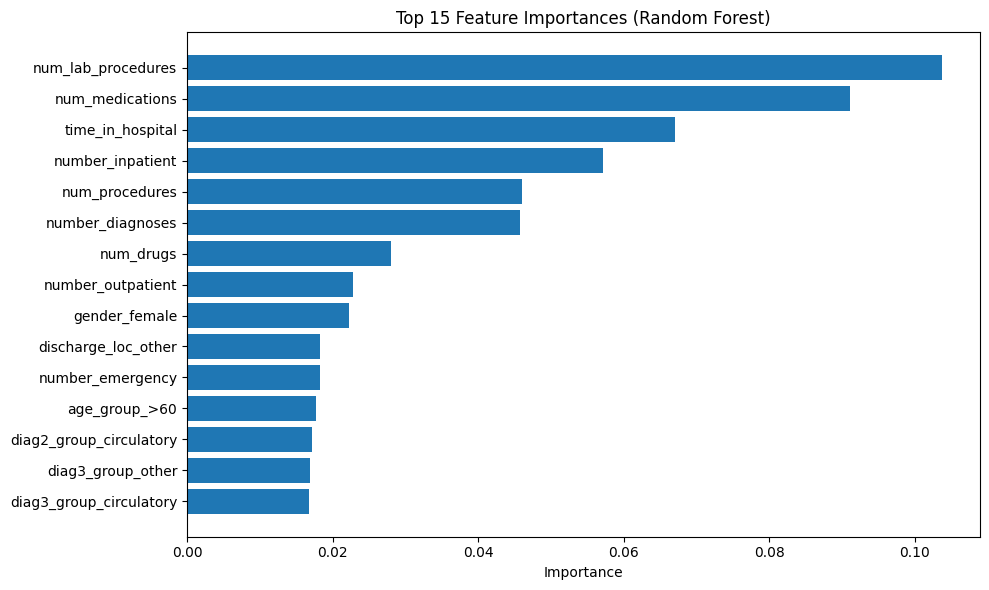

In [ ]:
cv_rf = make_cv()

rf_imp_df = cv_feature_importance(make_rf_pipe, X_train, y_train, cv_rf)
print(rf_imp_df.head())
plot_feature_importance(rf_imp_df, 'feature', 'importance_mean', 15, "Top 15 Feature Importances (Random Forest)")

### Permutation Importance of Features

                     feature  importance_mean  importance_std
6           number_inpatient         0.063328        0.006987
36       discharge_loc_other         0.020938        0.004199
0           time_in_hospital         0.006390        0.003419
5           number_emergency         0.005507        0.002671
7           number_diagnoses         0.004210        0.001794
3            num_medications         0.003339        0.002963
1         num_lab_procedures         0.002940        0.003041
2             num_procedures         0.002892        0.001970
45             age_group_>60         0.001895        0.001764
15   diag1_group_respiratory         0.001854        0.001807
37  specialty_cat_cardiology         0.001854        0.000817
4          number_outpatient         0.001078        0.002192
55               change_flag         0.000952        0.001392
46             gender_female         0.000883        0.001796
47            a1c_group_high         0.000882        0.000716


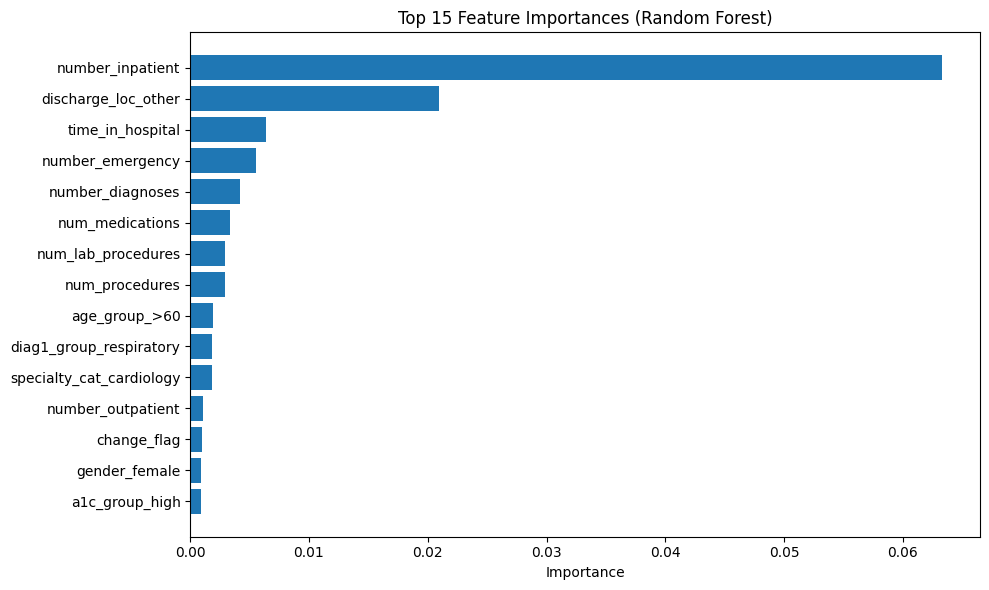

In [ ]:
rf_perm_imp_df = cv_permutation_importance(make_rf_pipe, X_train, y_train, cv_rf)
print(rf_perm_imp_df.head(15))
plot_feature_importance(rf_perm_imp_df, 'feature', 'importance_mean', 15, 'Permutation Importance (Random Forest)')



Permutation importance reveals that the model is heavily leaning on the number of inpatient procedures for its predictions.


### Comparison of feature importance with different data sets

The above section shows feature importance plots for the data set without interaction terms

below I'll add the interaction terms

In [16]:
# get data with the interaction terms (linear data set)

df_int = pd.read_csv('../data/linear_frame.csv', index_col=0)

X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(df_int.drop(columns=['target']), df['target'], stratify=df['target'], random_state=42)







              feature  importance_mean  importance_std
1  num_lab_procedures         0.082923        0.000403
3     num_medications         0.073764        0.000424
6    number_inpatient         0.050704        0.001283
0    time_in_hospital         0.044150        0.000767
7    number_diagnoses         0.037916        0.000413


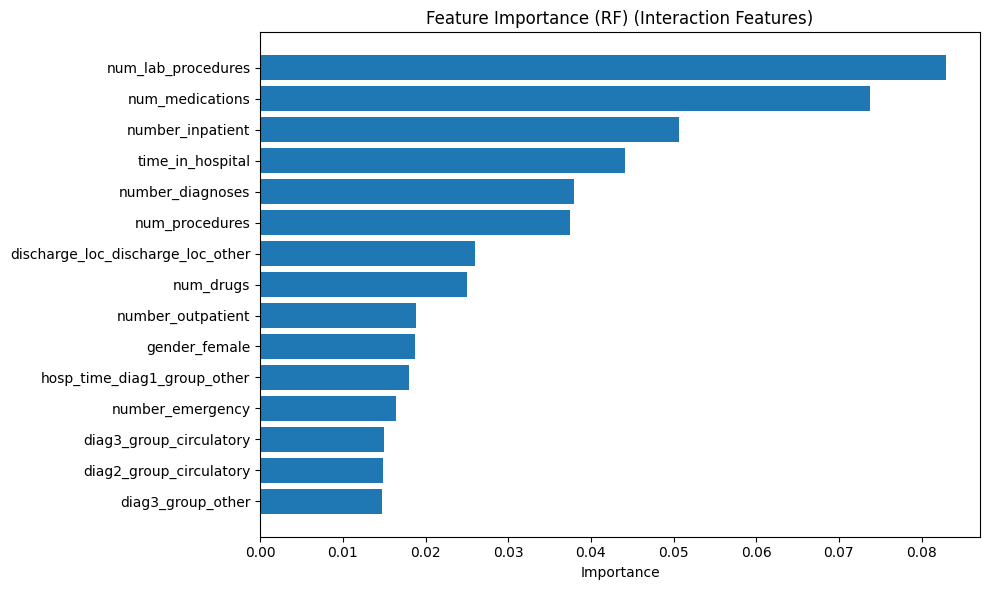

In [ ]:
cv_rf_int = make_cv()

feat_imp_rf_int = cv_feature_importance(make_rf_pipe, X_train_int, y_train_int, cv_rf_int)

print(feat_imp_rf_int.head())
plot_feature_importance(feat_imp_rf_int, 'feature', 'importance_mean', 15, 'Feature Importance (RF) (Interaction Features)')

                              feature  importance_mean  importance_std
6                    number_inpatient         0.048828        0.006817
72  discharge_loc_discharge_loc_other         0.006045        0.002413
36                discharge_loc_other         0.004702        0.002452
5                    number_emergency         0.004187        0.001525
3                     num_medications         0.003014        0.002875


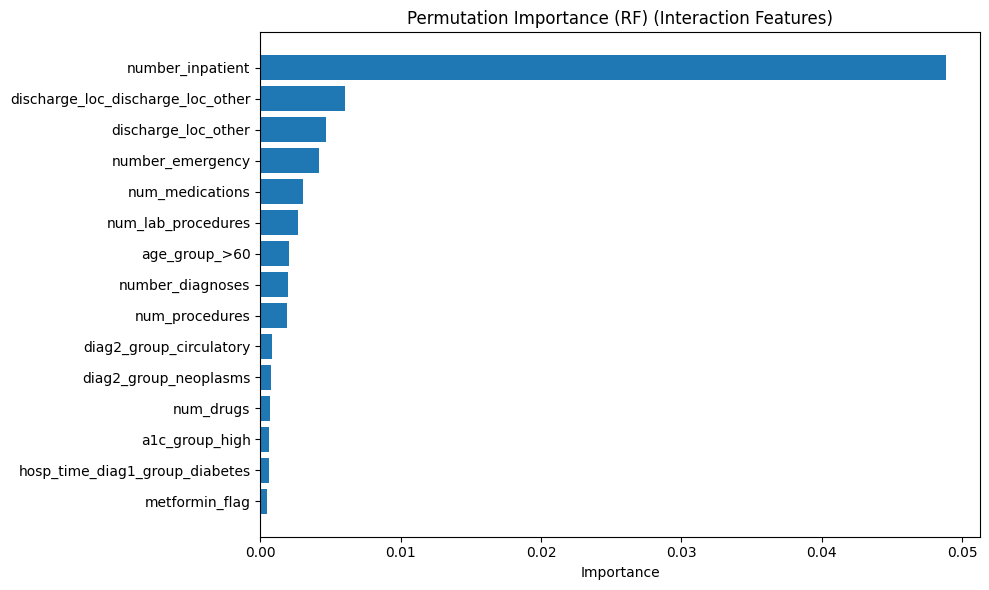

In [21]:
feat_perm_rt_int = cv_permutation_importance(make_rf_pipe, X_train_int, y_train_int, cv_rf_int)

print(feat_perm_rt_int.head())
plot_feature_importance(feat_perm_rt_int, 'feature', 'importance_mean', 15, 'Permutation Importance (RF) (Interaction Features)')

The above analysis leads me to believe I may have over simplified the discharge location (disposition) columns from the original data set as well as potentially losing information in the up/down signals from the medication groups. A more complex model might be needed to understand the different drug signals, but the work of *Monira, Mahmoud et al.* discusses dropping several of the drug columns due to lack of variance so more investigation into the drug data is required. 

For now, I will add a hyperparameter sweep using the random forest model to see if its performance can be increased.

### Hyperparameter Search for Random Forest

In [31]:
from sklearn.model_selection import RandomizedSearchCV


pipe_h = make_rf_pipe()

param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', 0.2, 0.5],
    'model__class_weight': [None, 'balanced']
}

rs = RandomizedSearchCV(
    estimator=pipe_h,
    param_distributions=param_grid,
    n_iter=30,
    scoring='roc_auc',
    cv=make_cv(),
    n_jobs=-1,
    random_state=42,
    refit=True
    )


rs.fit(X_train, y_train)

print("Best ROC AUC (cv):", rs.best_score_)
print("Best params:", rs.best_params_)

# Summarize top results
res_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
res_df[['rank_test_score','mean_test_score','std_test_score','params']].head(10)

/home/mike/Git-projects/Eaton_633_Project/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best ROC AUC (cv): 0.6519589056824839
Best params: {'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 10, 'model__class_weight': 'balanced'}


,rank_test_score,mean_test_score,std_test_score,params
0,1,0.651959,0.006095,"{'model__n_estimators': 500, 'model__min_sampl..."
1,2,0.651845,0.006322,"{'model__n_estimators': 500, 'model__min_sampl..."
2,3,0.651674,0.006436,"{'model__n_estimators': 500, 'model__min_sampl..."
3,4,0.651173,0.006392,"{'model__n_estimators': 500, 'model__min_sampl..."
4,5,0.650275,0.007498,"{'model__n_estimators': 500, 'model__min_sampl..."
5,6,0.649547,0.005940,"{'model__n_estimators': 500, 'model__min_sampl..."
6,7,0.649450,0.006758,"{'model__n_estimators': 200, 'model__min_sampl..."
7,8,0.649381,0.006841,"{'model__n_estimators': 500, 'model__min_sampl..."
8,9,0.649110,0.006837,"{'model__n_estimators': 200, 'model__min_sampl..."
9,10,0.648933,0.007548,"{'model__n_estimators': 200, 'model__min_sampl..."


In [32]:
# predict on held out test set
y_proba = rs.best_estimator_.predict_proba(X_test)[:, 1] #type: ignore

In [37]:

# roc auc
print('Held Out Test Metrics (Random Forest)')
print('ROC AUC:', roc_auc_score(y_test, y_proba))


Held Out Test Metrics (Random Forest)
ROC AUC: 0.658202523741052
